Init

In [109]:
import pyhilbert
import sympy as sy
from sympy import ImmutableDenseMatrix
import numpy as np

# Display sympy expressions nicely
sy.init_printing(use_unicode=True) 

# Building a 3D Diamond Weyl Semimetal

This notebook demonstrates how to construct a diamond lattice Weyl semimetal in real space using PyHilbert.

## Key Steps:
1. Define the diamond lattice (FCC with 2-atom basis)
2. Create sublattices A and B
3. Define orbital and spin degrees of freedom
4. Build the Hilbert space
5. Construct the tight-binding Hamiltonian
6. Find Weyl points in the Brillouin zone


## Step 1: Define the Diamond Lattice

Diamond structure = FCC lattice + 2-atom basis
- Sublattice A at (0, 0, 0)
- Sublattice B at (a/4, a/4, a/4) in Cartesian coordinates


In [110]:
from pyhilbert.spatials import Lattice, Offset

# Define lattice constant
a = sy.Symbol('a', real=True, positive=True)

# FCC lattice vectors (columns are basis vectors)
# Convention: lattice vectors in 3D Cartesian space
basis_matrix = ImmutableDenseMatrix([
    [0, a/2, a/2],      # a1 = (0, a/2, a/2)
    [a/2, 0, a/2],      # a2 = (a/2, 0, a/2)
    [a/2, a/2, 0]       # a3 = (a/2, a/2, 0)
])

# Create real space lattice with N×N×N unit cells
N = 4  # Number of unit cells per dimension
diamond_lattice = Lattice(basis=basis_matrix, shape=(N, N, N))

print("Diamond (FCC) Lattice:")
print(diamond_lattice)
print(f"\nLattice dimension: {diamond_lattice.dim}")
print(f"Total unit cells: {N**3}")


Diamond (FCC) Lattice:
AffineSpace(basis=[['0', 'a/2', 'a/2'], ['a/2', '0', 'a/2'], ['a/2', 'a/2', '0']])

Lattice dimension: 3
Total unit cells: 64


## Step 2: Define Sublattices A and B

In diamond, there are two interpenetrating FCC sublattices offset by (1/4, 1/4, 1/4) in lattice coordinates.


In [111]:
# Sublattice A at origin (0, 0, 0) in FCC lattice coordinates
sublattice_A = Offset(
    rep=ImmutableDenseMatrix([0, 0, 0]),
    space=diamond_lattice.affine
)

# Sublattice B at (1/4, 1/4, 1/4) in FCC lattice coordinates
# This translates to (a/4, a/4, a/4) in Cartesian coordinates
sublattice_B = Offset(
    rep=ImmutableDenseMatrix([sy.Rational(1, 4), sy.Rational(1, 4), sy.Rational(1, 4)]),
    space=diamond_lattice.affine
)

print("Sublattice A:")
print(sublattice_A)
print("\nSublattice B:")
print(sublattice_B)


Sublattice A:
Offset(['0', '0', '0'] ∈ [['0', 'a/2', 'a/2'], ['a/2', '0', 'a/2'], ['a/2', 'a/2', '0']])

Sublattice B:
Offset(['1/4', '1/4', '1/4'] ∈ [['0', 'a/2', 'a/2'], ['a/2', '0', 'a/2'], ['a/2', 'a/2', '0']])


## Step 3: Define Orbital and Spin Degrees of Freedom

For a minimal Weyl semimetal model, we use:
- **Orbitals**: s-orbital (can extend to s and p orbitals)
- **Spin**: spin-up and spin-down


In [112]:
from pyhilbert.spatials import PointGroupBasis
from pyhilbert.hilbert import Mode
from pyhilbert.utils import FrozenDict

# Define coordinate symbols for orbital wavefunctions
x, y, z = sy.symbols('x y z', real=True)

# s-orbital (spherically symmetric, A1 representation)
s_orbital = PointGroupBasis(
    expr=sy.Integer(1),  # constant function
    axes=(x, y, z),
    order=0,
    rep=ImmutableDenseMatrix([1])
)

print("s-orbital basis:")
print(s_orbital)

# Define spin states
spin_up = FrozenDict({'label': 'up', 'sz': sy.Rational(1, 2)})
spin_down = FrozenDict({'label': 'down', 'sz': sy.Rational(-1, 2)})

print("\nSpin states defined: ↑ (sz=+1/2) and ↓ (sz=-1/2)")


s-orbital basis:
PointGroupBasis(1)

Spin states defined: ↑ (sz=+1/2) and ↓ (sz=-1/2)


## Step 4: Build the Hilbert Space

Combine sublattice, orbital, and spin degrees of freedom into modes, then construct the full Hilbert space.


In [113]:
from pyhilbert.hilbert import hilbert

# Build modes for all combinations: 2 sublattices × 2 spins = 4 modes
modes = []

for sublat_name, sublat_offset in [('A', sublattice_A), ('B', sublattice_B)]:
    for spin_name, spin_data in [('up', spin_up), ('down', spin_down)]:
        mode = Mode(
            count=1,  # 1 state per mode
            attr=FrozenDict({
                'sublattice': sublat_name,
                'position': sublat_offset,
                'orbital': s_orbital,
                'spin': spin_data['label'],
                'sz': spin_data['sz']
            })
        )
        modes.append(mode)
        print(f"Mode: sublattice {sublat_name}, spin {spin_name}, sz={spin_data['sz']}")

# Create Hilbert space from all modes
H_space = hilbert(modes)

print(f"\n{'='*50}")
print(f"Total Hilbert space dimension: {H_space.dim}")
print(f"This represents {H_space.dim} basis states per unit cell")
print(f"{'='*50}")


Mode: sublattice A, spin up, sz=1/2
Mode: sublattice A, spin down, sz=-1/2
Mode: sublattice B, spin up, sz=1/2
Mode: sublattice B, spin down, sz=-1/2

Total Hilbert space dimension: 4
This represents 4 basis states per unit cell


## Step 5: Get Reciprocal Lattice and Brillouin Zone

The reciprocal lattice is automatically computed from the real space lattice.


In [114]:
from pyhilbert.hilbert import brillouin_zone

# Get reciprocal lattice (automatically computes via dual property)
reciprocal_lattice = diamond_lattice.dual

print("Reciprocal Lattice (BCC for FCC):")
print(reciprocal_lattice)
print(f"\nReciprocal lattice basis vectors (multiplied by 2π):")
print(reciprocal_lattice.basis)

# Create Brillouin zone (momentum space)
BZ = brillouin_zone(reciprocal_lattice)

print(f"\n{'='*50}")
print(f"Brillouin Zone points: {BZ.dim}")
print(f"This gives a {N}×{N}×{N} k-point mesh")
print(f"{'='*50}")


Reciprocal Lattice (BCC for FCC):
AffineSpace(basis=[['-2*pi/a', '2*pi/a', '2*pi/a'], ['2*pi/a', '-2*pi/a', '2*pi/a'], ['2*pi/a', '2*pi/a', '-2*pi/a']])

Reciprocal lattice basis vectors (multiplied by 2π):
Matrix([[-2*pi/a, 2*pi/a, 2*pi/a], [2*pi/a, -2*pi/a, 2*pi/a], [2*pi/a, 2*pi/a, -2*pi/a]])

Brillouin Zone points: 64
This gives a 4×4×4 k-point mesh


## Step 6: Hamiltonian Construction for Weyl Semimetal

The tight-binding Hamiltonian for a Weyl semimetal needs:
1. **Nearest-neighbor hopping** (t) between sublattices A and B
2. **On-site energy difference** (Δ) to break inversion symmetry
3. **Spin-orbit coupling** (λ_SO) 
4. **Time-reversal breaking** (m) via magnetic field or exchange

The minimal Weyl Hamiltonian in k-space:
$$H(\\mathbf{k}) = h_0(\\mathbf{k}) \\sigma_0 + \\sum_{i=x,y,z} h_i(\\mathbf{k}) \\sigma_i$$

where σ are Pauli matrices acting on sublattice space.


In [ ]:
import torch
from pyhilbert.tensors import Tensor
# Tight-binding parameters (in eV)
t = 1.0      # Nearest-neighbor hopping
Delta = 0.0  # On-site energy difference (breaks inversion)
m = 0.0    # Time-reversal breaking mass
lambda_so = 0.0  # Spin-orbit coupling

# Pauli matrices (for sublattice pseudospin)
sigma_0 = torch.eye(2, dtype=torch.complex128)
sigma_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128)
sigma_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128)
sigma_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)

# Pauli matrices for spin
tau_0 = torch.eye(2, dtype=torch.complex128)
tau_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128)
tau_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128)
tau_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)

print("Tight-binding parameters:")
print(f"  Hopping t = {t} eV")
print(f"  Inversion breaking Δ = {Delta} eV")
print(f"  TR breaking mass m = {m} eV")
print(f"  Spin-orbit λ_SO = {lambda_so} eV")


Tight-binding parameters:
  Hopping t = 1.0 eV
  Inversion breaking Δ = 0.0 eV
  TR breaking mass m = 0.0 eV
  Spin-orbit λ_SO = 0.5 eV


In [ ]:
# Helper function: Kronecker product for combining sublattice and spin
def kron(A, B):
    return torch.kron(A, B)

# Build Hamiltonian for each k-point
# H_data shape: (num_k_points, H_space.dim, H_space.dim)
# H_space.dim = 4 (2 sublattices × 2 spins)

H_data = torch.zeros((BZ.dim, H_space.dim, H_space.dim), dtype=torch.complex128)

# Get k-points from BZ
from pyhilbert.spatials import cartes
k_points = cartes(reciprocal_lattice)

print(f"Building Hamiltonian for {len(k_points)} k-points...")

for idx, k_momentum in enumerate(k_points):
    # Extract k-vector components
    k_vec = k_momentum.rep 
    kx = float(k_vec[0])
    ky = float(k_vec[1]) 
    kz = float(k_vec[2])
    
    # 1. Base Terms (Kinetic + Mass)
    hx = t * torch.sin(torch.tensor(2*np.pi*kx))
    hy = t * torch.sin(torch.tensor(2*np.pi*ky))
    hz = t * torch.sin(torch.tensor(2*np.pi*kz)) + Delta
    h0 = m
    
    H_base = (h0 * kron(sigma_0, tau_z) + 
              hx * kron(sigma_x, tau_0) +
              hy * kron(sigma_y, tau_0) +
              hz * kron(sigma_z, tau_0))
              
    # 2. Add Spin-Orbit Coupling (New Term)
    # This couples Sublattice (sigma) with Spin (tau)
    # H_soc = lambda * [sin(kx)σxτx + sin(ky)σyτy + sin(kz)σzτz]
    
    H_soc = lambda_so * (
        torch.sin(torch.tensor(2*np.pi*kx)) * kron(sigma_x, tau_x) +
        torch.sin(torch.tensor(2*np.pi*ky)) * kron(sigma_y, tau_y) +
        torch.sin(torch.tensor(2*np.pi*kz)) * kron(sigma_z, tau_z)
    )
    
    # Total Hamiltonian
    H_k = H_base + H_soc
    
    H_data[idx, :, :] = H_k

print(f"Hamiltonian constructed with shape: {H_data.shape}")
print(f"  Dimension 0: {BZ.dim} k-points")
print(f"  Dimensions 1,2: {H_space.dim}×{H_space.dim} Hilbert space")


Building Hamiltonian for 64 k-points...
Hamiltonian constructed with shape: torch.Size([64, 4, 4])
  Dimension 0: 64 k-points
  Dimensions 1,2: 4×4 Hilbert space


## Step 7: Compute Band Structure and Find Weyl Points

Weyl points occur where two bands touch (band crossing) with linear dispersion.


In [117]:
# Diagonalize Hamiltonian at each k-point
eigenvalues = torch.zeros((BZ.dim, H_space.dim), dtype=torch.float64)
eigenvectors = torch.zeros((BZ.dim, H_space.dim, H_space.dim), dtype=torch.complex128)

print("Diagonalizing Hamiltonian...")
for idx in range(BZ.dim):
    # Get eigenvalues and eigenvectors
    evals, evecs = torch.linalg.eigh(H_data[idx])
    eigenvalues[idx] = evals
    eigenvectors[idx] = evecs

print(f"Band structure computed!")
print(f"Shape of eigenvalues: {eigenvalues.shape}")
print(f"  {eigenvalues.shape[0]} k-points")
print(f"  {eigenvalues.shape[1]} bands")

# Find band gaps (potential Weyl points where gap closes)
band_gaps = torch.zeros(BZ.dim)
for idx in range(BZ.dim):
    # Gap between highest valence and lowest conduction band
    sorted_evals = torch.sort(eigenvalues[idx])[0]
    # Assuming Fermi level at E=0, find bands around it
    band_gaps[idx] = sorted_evals[H_space.dim//2] - sorted_evals[H_space.dim//2 - 1]

min_gap = torch.min(band_gaps)
min_gap_idx = torch.argmin(band_gaps)

print(f"\n{'='*50}")
print(f"Minimum band gap: {min_gap:.6f} eV")
print(f"Located at k-point index: {min_gap_idx}")
print(f"k-vector: {k_points[min_gap_idx]}")
print(f"{'='*50}")

if abs(min_gap) < 0.01:
    print("\n⚠️  Small gap detected! Possible Weyl point nearby.")
    print("    Fine-tune parameters (m, Δ, λ_SO) to find exact Weyl point.")
else:
    print(f"\nCurrent gap = {min_gap:.4f} eV")
    print("Adjust parameters to close the gap and find Weyl points.")


Diagonalizing Hamiltonian...
Band structure computed!
Shape of eigenvalues: torch.Size([64, 4])
  64 k-points
  4 bands

Minimum band gap: 0.000000 eV
Located at k-point index: 0
k-vector: Offset(['0', '0', '0'] ∈ [['-2*pi/a', '2*pi/a', '2*pi/a'], ['2*pi/a', '-2*pi/a', '2*pi/a'], ['2*pi/a', '2*pi/a', '-2*pi/a']])

⚠️  Small gap detected! Possible Weyl point nearby.
    Fine-tune parameters (m, Δ, λ_SO) to find exact Weyl point.


## Summary and Key Takeaways

### PyHilbert Framework Components Used:

1. **`Lattice`**: Defines FCC lattice with basis vectors
2. **`Offset`**: Positions of sublattices A and B  
3. **`PointGroupBasis`**: Orbital wavefunctions (s, p, d orbitals)
4. **`Mode`**: Combines position, orbital, and spin quantum numbers
5. **`HilbertSpace`**: Complete basis for the quantum system
6. **`ReciprocalLattice`**: Momentum space via `.dual` property
7. **`brillouin_zone()`**: Generates k-point mesh

### To Create a Full Weyl Semimetal:

1. **Refine the Hamiltonian**: Include proper diamond structure factors for nearest-neighbor hopping
2. **Add Spin-Orbit Coupling**: Mix spin states with orbital angular momentum
3. **Tune Parameters**: Adjust t, Δ, m, λ_SO to achieve band touchings
4. **Increase k-mesh**: Use finer grid (larger N) to accurately locate Weyl points
5. **Compute Berry Curvature**: Calculate topological charge at Weyl nodes
6. **Find Fermi Arcs**: Compute surface states on a slab geometry

### Next Steps:

- **Extend to p-orbitals**: Include px, py, pz for more realistic model
- **Add more neighbors**: Include 2nd, 3rd nearest-neighbor hoppings
- **Implement symmetry constraints**: Use `AbelianGroup` for point group operations
- **Compute topological invariants**: Berry phase, Chern number


## Optional: Visualize Band Structure

Uncomment and run to plot the band structure along high-symmetry lines.


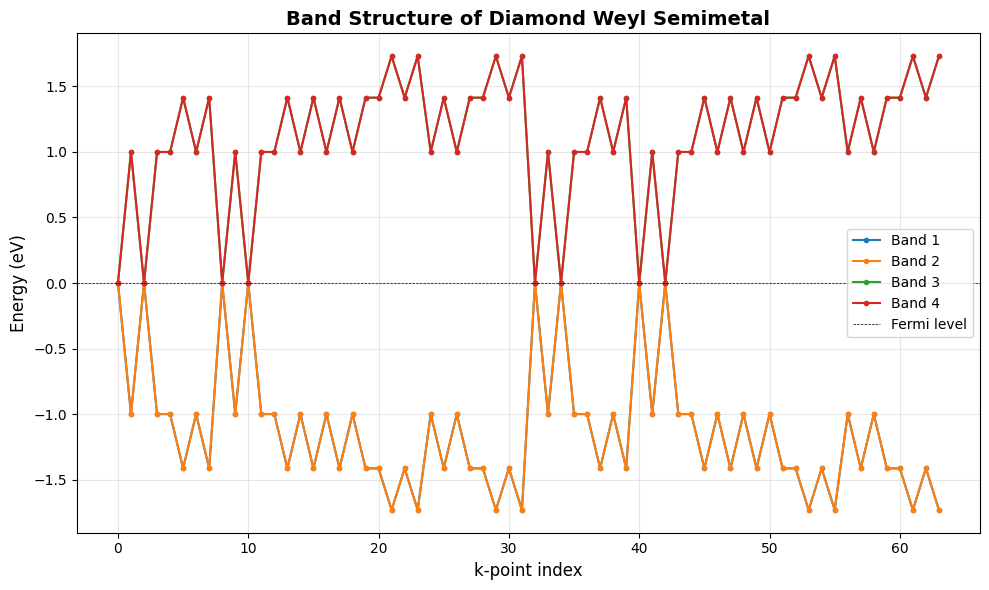

Visualization code ready. Uncomment to plot band structure.


In [118]:
# Uncomment to visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot all bands
for band_idx in range(H_space.dim):
    ax.plot(eigenvalues[:, band_idx].numpy(), 'o-', markersize=3, label=f'Band {band_idx+1}')

ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5, label='Fermi level')
ax.set_xlabel('k-point index', fontsize=12)
ax.set_ylabel('Energy (eV)', fontsize=12)
ax.set_title('Band Structure of Diamond Weyl Semimetal', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualization code ready. Uncomment to plot band structure.")


## High-Symmetry k-path: Γ→K→W→K→Γ→L→U→W→L→K

For an FCC lattice (BCC reciprocal lattice), we define high-symmetry points and create a path through the Brillouin zone.


In [ ]:
# Define high-symmetry points in the BZ (in fractional coordinates of reciprocal lattice)
# For BCC reciprocal lattice (dual of FCC), standard points are:

high_sym_points = {
    'Gamma': np.array([0.0, 0.0, 0.0]),           # Γ: center
    'X': np.array([0.0, 0.5, 0.0]),               # X: face center
    'L': np.array([0.5, 0.5, 0.5]),               # L: corner
    'W': np.array([0.25, 0.75, 0.5]),             # W: between K and X
    'K': np.array([0.375, 0.75, 0.375]),          # K: edge
    'U': np.array([0.25, 0.625, 0.625])           # U: another special point
}

# Define the path: Γ→K→W→K→Γ→L→U→W→L→K
path_labels = ['Gamma', 'K', 'W', 'K', 'Gamma', 'L', 'U', 'W', 'L', 'K']

# Number of k-points between each high-symmetry point
num_points_per_segment = 30

print("High-symmetry points defined:")
for label, coords in high_sym_points.items():
    print(f"  {label}: {coords}")
    
print(f"\nPath: {' → '.join(path_labels)}")


High-symmetry points defined:
  Gamma: [0. 0. 0.]
  X: [0.  0.5 0. ]
  L: [0.5 0.5 0.5]
  W: [0.25 0.75 0.5 ]
  K: [0.375 0.75  0.375]
  U: [0.25  0.625 0.625]

Path: Gamma → K → W → K → Gamma → L → U → W → L → K


In [ ]:
# Generate k-points along the path
k_path = []
k_distances = [0]  # Track cumulative distance for x-axis
segment_boundaries = [0]  # Track where segments change for vertical lines

current_distance = 0

for i in range(len(path_labels) - 1):
    start_label = path_labels[i]
    end_label = path_labels[i + 1]
    
    start_point = high_sym_points[start_label]
    end_point = high_sym_points[end_label]
    
    # Generate linear interpolation between points
    for j in range(num_points_per_segment):
        t = j / num_points_per_segment
        k_point = (1 - t) * start_point + t * end_point
        k_path.append(k_point)
        
        if len(k_path) > 1:
            # Calculate Euclidean distance in k-space
            dk = np.linalg.norm(k_point - k_path[-2])
            current_distance += dk
            k_distances.append(current_distance)
    
    # Mark segment boundary
    segment_boundaries.append(len(k_path))

# Add the final point
k_path.append(high_sym_points[path_labels[-1]])
if len(k_path) > 1:
    dk = np.linalg.norm(k_path[-1] - k_path[-2])
    current_distance += dk
k_distances.append(current_distance)

k_path = np.array(k_path)
k_distances = np.array(k_distances)

print(f"Generated {len(k_path)} k-points along the path")
print(f"Total path length in k-space: {k_distances[-1]:.4f}")


Generated 271 k-points along the path
Total path length in k-space: 4.1994


In [ ]:
# Compute Hamiltonian and diagonalize for each k-point along the path
num_k = len(k_path)
eigenvalues_path = torch.zeros((num_k, H_space.dim), dtype=torch.float64)

print(f"Computing band structure along path ({num_k} k-points)...")

for idx, k_vec in enumerate(k_path):
    # Extract k-vector components (fractional coordinates)
    kx, ky, kz = k_vec[0], k_vec[1], k_vec[2]
    
    # Dispersion terms using the same model as before
    hx = t * torch.sin(torch.tensor(2*np.pi*kx))
    hy = t * torch.sin(torch.tensor(2*np.pi*ky))
    hz = t * torch.sin(torch.tensor(2*np.pi*kz)) + Delta
    h0 = m
    
    # Build H(k) = h0·I ⊗ τ_z + hx·σ_x ⊗ τ_0 + hy·σ_y ⊗ τ_0 + hz·σ_z ⊗ τ_0
    H_k = (h0 * kron(sigma_0, tau_z) + 
           hx * kron(sigma_x, tau_0) +
           hy * kron(sigma_y, tau_0) +
           hz * kron(sigma_z, tau_0))
    
    # Diagonalize
    evals, _ = torch.linalg.eigh(H_k)
    eigenvalues_path[idx] = evals

print("Band structure computation complete!")
print(f"Eigenvalues shape: {eigenvalues_path.shape}")


Computing band structure along path (271 k-points)...
Band structure computation complete!
Eigenvalues shape: torch.Size([271, 4])


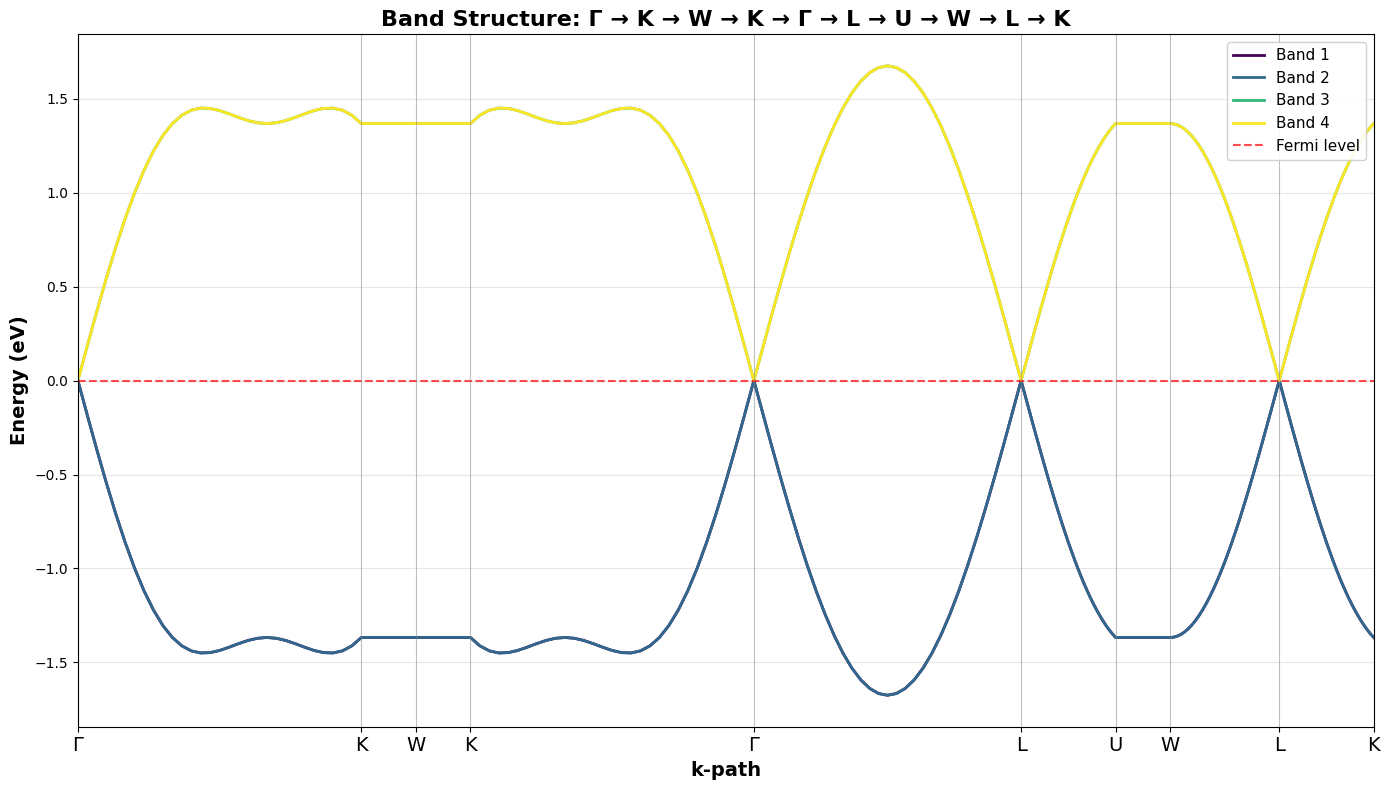


Band structure plotted along path: Γ → K → W → K → Γ → L → U → W → L → K
Total number of k-points: 271
Number of bands: 4


In [ ]:
# Plot band structure along the high-symmetry path
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each band
colors = plt.cm.viridis(np.linspace(0, 1, H_space.dim))
for band_idx in range(H_space.dim):
    ax.plot(k_distances, eigenvalues_path[:, band_idx].numpy(), 
            linewidth=2, color=colors[band_idx], label=f'Band {band_idx+1}')

# Add Fermi level
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Fermi level')

# Add vertical lines at high-symmetry points
unique_positions = []
unique_labels = []
for i, boundary_idx in enumerate(segment_boundaries[:-1]):
    x_pos = k_distances[boundary_idx]
    if not unique_positions or abs(x_pos - unique_positions[-1]) > 1e-6:
        ax.axvline(x=x_pos, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
        unique_positions.append(x_pos)
        unique_labels.append(path_labels[i])

# Add final point
final_x = k_distances[-1]
if abs(final_x - unique_positions[-1]) > 1e-6:
    ax.axvline(x=final_x, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    unique_positions.append(final_x)
    unique_labels.append(path_labels[-1])

# Format labels (use Greek letters)
def format_label(label):
    if label == 'Gamma':
        return 'Γ'
    return label

formatted_labels = [format_label(l) for l in unique_labels]

# Set x-axis labels
ax.set_xticks(unique_positions)
ax.set_xticklabels(formatted_labels, fontsize=14)

# Labels and formatting
ax.set_xlabel('k-path', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (eV)', fontsize=14, fontweight='bold')
ax.set_title(f'Band Structure: {" → ".join(formatted_labels)}', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlim(k_distances[0], k_distances[-1])

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Band structure plotted along path: {' → '.join(formatted_labels)}")
print(f"Total number of k-points: {num_k}")
print(f"Number of bands: {H_space.dim}")
print(f"{'='*60}")


## Real Space Visualization of Diamond Lattice

Visualize the diamond lattice structure showing sublattices A and B in 3D.


In [ ]:
# Generate real space positions for visualization
# We'll use a smaller lattice for visualization clarity
N_vis = 2  # 2x2x2 unit cells for clearer visualization

# Set lattice constant value for visualization (in arbitrary units)
a_val = 1.0

# FCC lattice vectors
a1 = np.array([0, a_val/2, a_val/2])
a2 = np.array([a_val/2, 0, a_val/2])
a3 = np.array([a_val/2, a_val/2, 0])

# Sublattice offsets in Cartesian coordinates
# A at origin, B at (a/4, a/4, a/4) in Cartesian
offset_A = np.array([0, 0, 0])
offset_B = np.array([a_val/4, a_val/4, a_val/4])

# Generate all lattice sites
sites_A = []
sites_B = []

for n1 in range(N_vis):
    for n2 in range(N_vis):
        for n3 in range(N_vis):
            # Position of unit cell
            R = n1 * a1 + n2 * a2 + n3 * a3
            
            # Add sublattice positions
            sites_A.append(R + offset_A)
            sites_B.append(R + offset_B)

sites_A = np.array(sites_A)
sites_B = np.array(sites_B)

print(f"Generated {len(sites_A)} sites for sublattice A")
print(f"Generated {len(sites_B)} sites for sublattice B")
print(f"Total atoms: {len(sites_A) + len(sites_B)}")


Generated 8 sites for sublattice A
Generated 8 sites for sublattice B
Total atoms: 16


In [ ]:
# Find nearest neighbor bonds between A and B sublattices
# In diamond, each atom has 4 nearest neighbors at distance a*sqrt(3)/4

nn_distance = a_val * np.sqrt(3) / 4
tolerance = 0.01  # Small tolerance for floating point comparison

bonds = []

for i, pos_A in enumerate(sites_A):
    for j, pos_B in enumerate(sites_B):
        dist = np.linalg.norm(pos_A - pos_B)
        if abs(dist - nn_distance) < tolerance:
            bonds.append((pos_A, pos_B))

print(f"Found {len(bonds)} nearest-neighbor bonds")
print(f"Nearest-neighbor distance: {nn_distance:.4f}")


Found 20 nearest-neighbor bonds
Nearest-neighbor distance: 0.4330


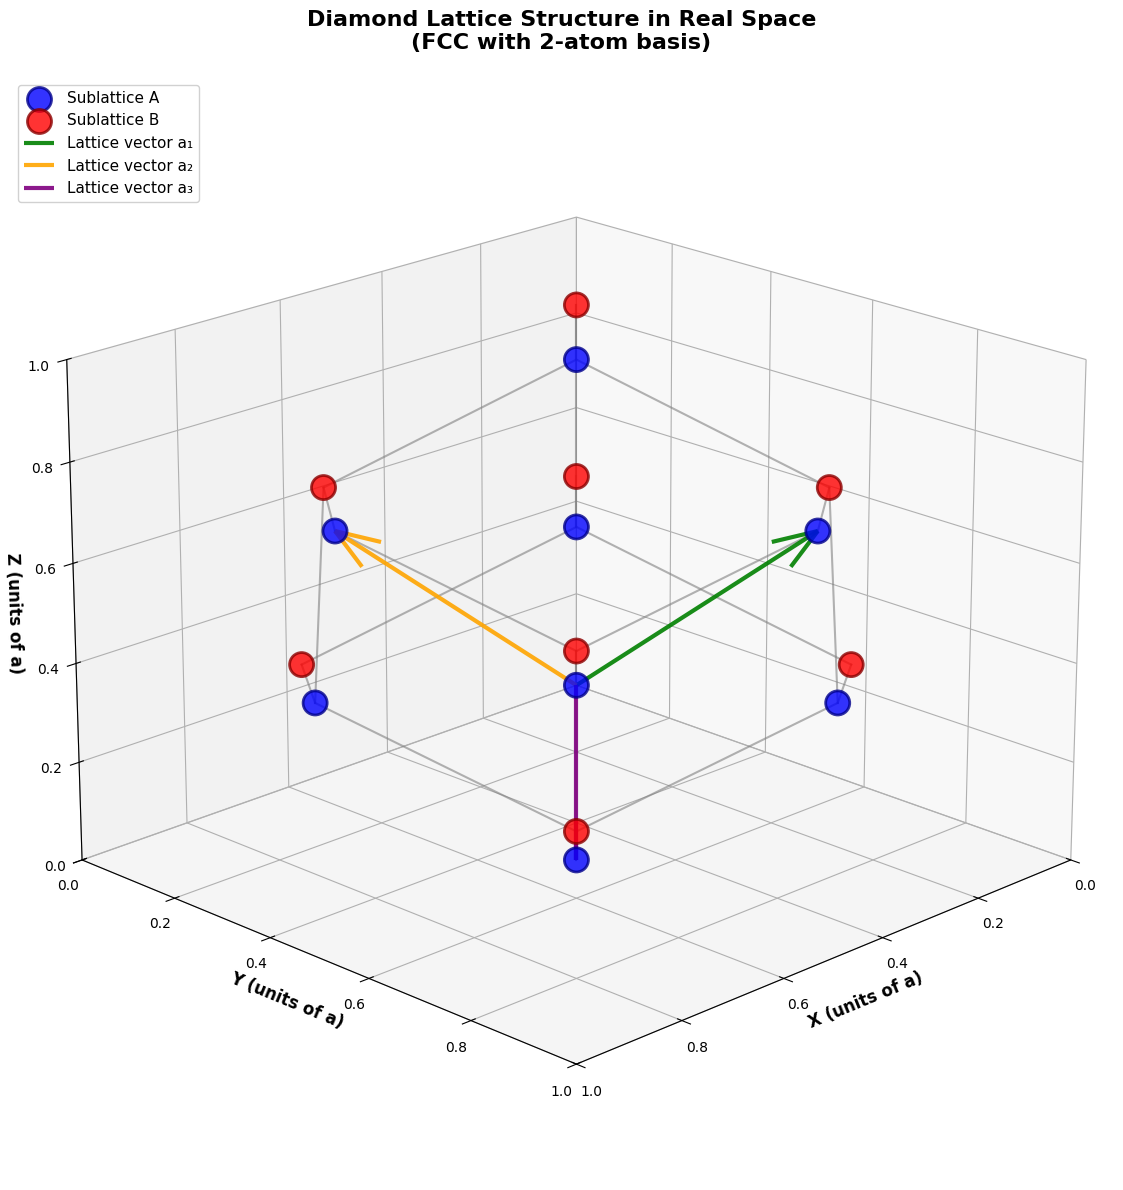


Diamond Lattice Structure:
  - Blue spheres: Sublattice A at (0, 0, 0)
  - Red spheres: Sublattice B at (a/4, a/4, a/4)
  - Gray lines: Nearest-neighbor bonds
  - Colored arrows: FCC lattice vectors a₁, a₂, a₃
  - Each atom has 4 nearest neighbors (tetrahedral coordination)


In [ ]:
# Create 3D visualization of diamond lattice
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot sublattice A (blue spheres)
ax.scatter(sites_A[:, 0], sites_A[:, 1], sites_A[:, 2], 
          c='blue', s=300, alpha=0.8, edgecolors='darkblue', 
          linewidth=2, label='Sublattice A', depthshade=True)

# Plot sublattice B (red spheres)
ax.scatter(sites_B[:, 0], sites_B[:, 1], sites_B[:, 2], 
          c='red', s=300, alpha=0.8, edgecolors='darkred', 
          linewidth=2, label='Sublattice B', depthshade=True)

# Plot bonds between nearest neighbors
for bond in bonds:
    pos_A, pos_B = bond
    ax.plot([pos_A[0], pos_B[0]], 
           [pos_A[1], pos_B[1]], 
           [pos_A[2], pos_B[2]], 
           'gray', linewidth=1.5, alpha=0.6)

# Plot lattice vectors from origin
origin = np.array([0, 0, 0])
arrow_props = dict(mutation_scale=20, lw=2, arrowstyle='->', color='black')

# Draw lattice vectors
for i, (vec, label, color) in enumerate([(a1, 'a₁', 'green'), 
                                           (a2, 'a₂', 'orange'), 
                                           (a3, 'a₃', 'purple')]):
    ax.quiver(origin[0], origin[1], origin[2], 
             vec[0], vec[1], vec[2], 
             color=color, arrow_length_ratio=0.15, linewidth=3, 
             label=f'Lattice vector {label}', alpha=0.9)

# Formatting
ax.set_xlabel('X (units of a)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y (units of a)', fontsize=12, fontweight='bold')
ax.set_zlabel('Z (units of a)', fontsize=12, fontweight='bold')
ax.set_title('Diamond Lattice Structure in Real Space\n(FCC with 2-atom basis)', 
            fontsize=16, fontweight='bold', pad=20)

ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

# Set equal aspect ratio
max_range = np.array([sites_A[:, 0].max() - sites_A[:, 0].min(),
                      sites_A[:, 1].max() - sites_A[:, 1].min(),
                      sites_A[:, 2].max() - sites_A[:, 2].min()]).max() / 2.0

mid_x = (sites_A[:, 0].max() + sites_A[:, 0].min()) * 0.5
mid_y = (sites_A[:, 1].max() + sites_A[:, 1].min()) * 0.5
mid_z = (sites_A[:, 2].max() + sites_A[:, 2].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Diamond Lattice Structure:")
print(f"  - Blue spheres: Sublattice A at (0, 0, 0)")
print(f"  - Red spheres: Sublattice B at (a/4, a/4, a/4)")
print(f"  - Gray lines: Nearest-neighbor bonds")
print(f"  - Colored arrows: FCC lattice vectors a₁, a₂, a₃")
print(f"  - Each atom has 4 nearest neighbors (tetrahedral coordination)")
print(f"{'='*60}")


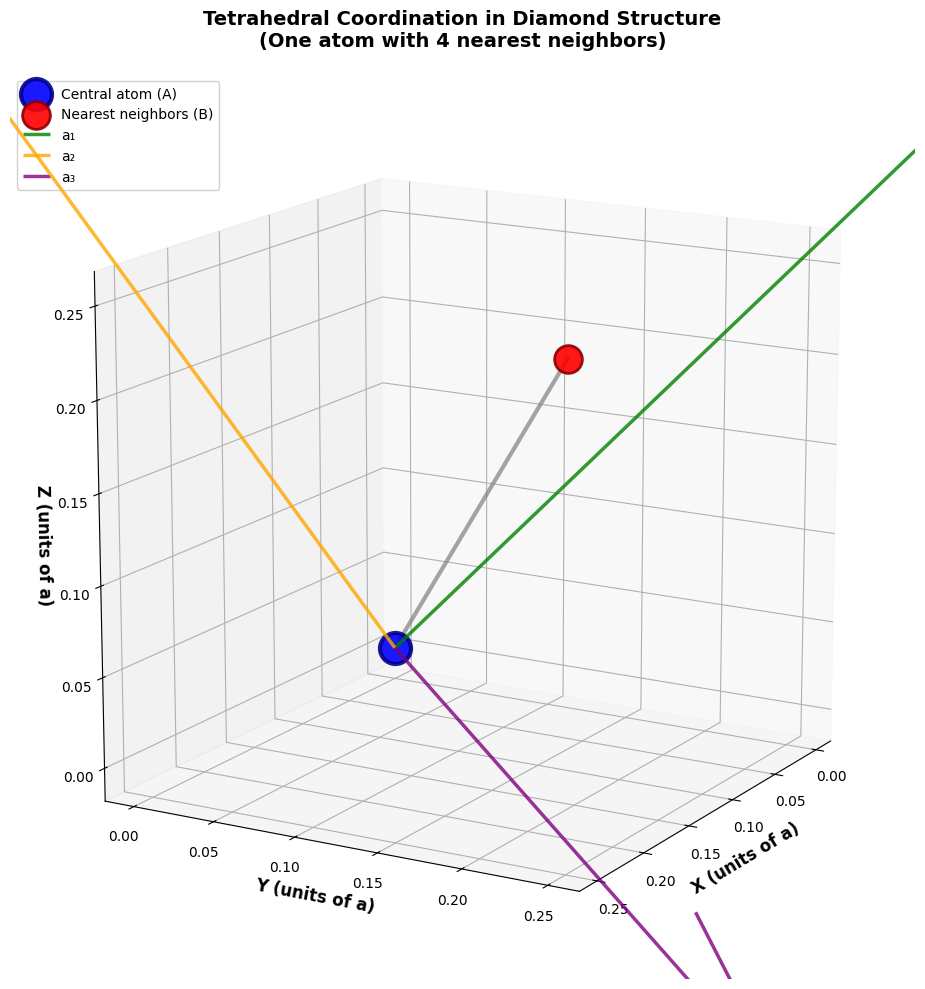


Tetrahedral Coordination:
  - Diamond structure has sp³ hybridization
  - Each atom bonds to 4 nearest neighbors
  - Bond angle ≈ 109.47° (tetrahedral angle)
  - This gives diamond its strong covalent bonding


In [ ]:
# Additional visualization: Show unit cell with tetrahedral coordination
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Focus on one unit cell - plot only first few atoms
# Show one A atom and its 4 nearest neighbors from B sublattice

center_A = sites_A[0]  # Origin atom from sublattice A

# Find its 4 nearest neighbors from B
neighbors_B = []
for pos_B in sites_B:
    dist = np.linalg.norm(center_A - pos_B)
    if abs(dist - nn_distance) < tolerance:
        neighbors_B.append(pos_B)

neighbors_B = np.array(neighbors_B)

# Plot central A atom (larger)
ax.scatter([center_A[0]], [center_A[1]], [center_A[2]], 
          c='blue', s=500, alpha=0.9, edgecolors='darkblue', 
          linewidth=3, label='Central atom (A)', depthshade=True)

# Plot 4 nearest neighbor B atoms
ax.scatter(neighbors_B[:, 0], neighbors_B[:, 1], neighbors_B[:, 2], 
          c='red', s=400, alpha=0.9, edgecolors='darkred', 
          linewidth=2, label='Nearest neighbors (B)', depthshade=True)

# Plot bonds
for pos_B in neighbors_B:
    ax.plot([center_A[0], pos_B[0]], 
           [center_A[1], pos_B[1]], 
           [center_A[2], pos_B[2]], 
           'gray', linewidth=3, alpha=0.7)

# Draw tetrahedral edges between B atoms
for i in range(len(neighbors_B)):
    for j in range(i+1, len(neighbors_B)):
        ax.plot([neighbors_B[i, 0], neighbors_B[j, 0]], 
               [neighbors_B[i, 1], neighbors_B[j, 1]], 
               [neighbors_B[i, 2], neighbors_B[j, 2]], 
               'red', linewidth=1, alpha=0.3, linestyle='--')

# Draw lattice vectors from origin
for i, (vec, label, color) in enumerate([(a1, 'a₁', 'green'), 
                                           (a2, 'a₂', 'orange'), 
                                           (a3, 'a₃', 'purple')]):
    ax.quiver(center_A[0], center_A[1], center_A[2], 
             vec[0], vec[1], vec[2], 
             color=color, arrow_length_ratio=0.2, linewidth=2.5, 
             label=f'{label}', alpha=0.8)

# Formatting
ax.set_xlabel('X (units of a)', fontsize=12, fontweight='bold')
ax.set_ylabel('Y (units of a)', fontsize=12, fontweight='bold')
ax.set_zlabel('Z (units of a)', fontsize=12, fontweight='bold')
ax.set_title('Tetrahedral Coordination in Diamond Structure\n(One atom with 4 nearest neighbors)', 
            fontsize=14, fontweight='bold', pad=20)

ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

# Set viewing angle for best view of tetrahedron
ax.view_init(elev=15, azim=30)

# Set equal aspect
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Tetrahedral Coordination:")
print(f"  - Diamond structure has sp³ hybridization")
print(f"  - Each atom bonds to 4 nearest neighbors")
print(f"  - Bond angle ≈ 109.47° (tetrahedral angle)")
print(f"  - This gives diamond its strong covalent bonding")
print(f"{'='*60}")


## Tuning Parameters for Simple Tight-Binding Model

### Parameter Effects:

1. **`t` (hopping)**: Controls bandwidth - larger t = wider bands
2. **`Delta` (inversion breaking)**: Shifts bands apart - set to 0 for symmetric model
3. **`m` (time-reversal breaking)**: Creates spin splitting - set to 0 for degenerate spins
4. **`lambda_so` (spin-orbit)**: Mixes spin states - set to 0 for pure spin states

### Simplest Tight-Binding Model:
Set `Delta = 0`, `m = 0`, `lambda_so = 0` and keep only `t ≠ 0`
